Installers<br>
pandas: !pip install pandas<br>
K-means: !pip install -U scikit-learn<br>
Matplotlib: !python -m pip install -U matplotlib<br>
nltk: !pip install nltk<br>
PySimpleGUI: !pip install pysimplegui

In [357]:
from asyncore import write
import pandas as pd
from doctest import DocTestFailure
import math
import string
from sklearn.cluster import KMeans
from sklearn.datasets._samples_generator import make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#----------- importando bibliotecas para tratar as palavras

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
from string import digits

#----------- Biblioteca para interface
import PySimpleGUI as sg

#----------- Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

#---------Aprendizagem Supervisionada
import re
import scipy
import itertools
import matplotlib
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\letic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [358]:
#----------- funções

def remove_punctuations(line): #remove caractéres e palavras comuns como o, a, um, uma etc
    newLine = ""
    for character in string.punctuation:
        line = line.replace(character, "")
    words = line.split()
    for word in words:
        if word.lower() not in stopwords:
            newLine = newLine + " " + word
    newLine = newLine.replace(digits, "")
    return newLine

def writeFile(dict, archiveName): #rpassa o dicionario para um arquivo txt
    arquivo = open(archiveName+".txt",'w')
    for word, tf in dict.items():
        sentence = f"{word}:{tf}\n"
        arquivo.write(sentence)
    arquivo.close()

def writeCSV(df, archiveName): #passa o dataframe para um arquivo csv
    f = open("..\\DataBase\\"+archiveName+".csv", 'w', newline='', encoding="utf8")
    df.to_csv("..\\DataBase\\"+archiveName+".csv", encoding="utf8", sep=';')


def countWords(wordsDoc, line):  #conta o total de palavras
    wordsCopy = wordsDoc.copy() 
    words = line.split()
    for word in words:
        word = word.lower()
        wordsCopy[word] += 1
    return wordsCopy

def get_posts():
    file = open(filepath, 'r', encoding="utf8")
    lines = file.readlines()
    return lines  

def calculate_idf (wordCount):
    resultIDF = {}
    N = 1 #n sempre vai ser 1 pq analisamos tweet a tweet

    resultIDF = dict.fromkeys(wordCount.keys(), 0)
    for word, val in wordCount.items():
        resultIDF[word] = abs(math.log10(N / (float(val) + 1)))
    return (resultIDF)

def toPandasDF(file):
    fileName = file + ".csv"
    newDF = pd.read_csv(fileName, sep=";")
    return newDF

In [359]:
#-------Vetorização

filepath = "posts.txt"
word_count = {}
lines = []
count_line = 0
listIDF = {}

In [360]:
with open(filepath, 'r') as fi:
    for line in fi:
        line = remove_punctuations(line)
        lines.append(line)
        words = line.split()

        for word in words:
            word = word.lower()
            if word not in word_count:
                word_count[word] = 0

In [361]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(lines)
dfTF = pd.DataFrame(word_count_vector.toarray(), columns = cv.get_feature_names())

vec = TfidfVectorizer()
tf_idf = vec.fit_transform(lines)
dfTF_IDF = pd.DataFrame(tf_idf.toarray(), columns=vec.get_feature_names())

In [362]:
rowCount = 0
for line in lines:
    rowCount += 1
    rowName = "Tweet" + str(rowCount)
    totalCount = countWords(word_count, line)
    idf_value = calculate_idf(totalCount)
    listIDF[rowName] = idf_value

In [363]:
dfIDF = pd.DataFrame.from_dict(listIDF, orient='index', columns=word_count.keys())   
writeCSV(dfTF, "TF")
writeCSV(dfTF_IDF , "TF_IDF")
writeCSV(dfIDF, "IDF")

FileNotFoundError: [Errno 2] No such file or directory: '..\\DataBase\\TF.csv'

In [9]:
#---------clusterização --- TF
def clusterizar(dfTF):
    x = np.array(dfTF)
    kmeans_model = KMeans (n_clusters=3, random_state=0, init='random', n_init=10, max_iter=300, tol=1e-04).fit(x)
    kmeans_model.labels_
    kmeans_model.cluster_centers_

    mydict = {i: np.where(kmeans_model.labels_ == i)[0] for i in range(kmeans_model.n_clusters)}
    dictlist = []
    for key, value in mydict.items():
        temp = [key,value]
        dictlist.append(temp)
        
    return dictlist

### Inserir coluna do grupo

In [10]:
#--------- Função para inserir coluna dos grupos
def insert_column(df_aux,dictlist):
    df_aux['group'] = ''
    for i in dictlist[0][1]:
        df_aux['group'][i-1] = 0

    for i in dictlist[1][1]:
        df_aux['group'][i-1] = 1

    for i in dictlist[2][1]:
        df_aux['group'][i-1] = 2
    
    return df_aux

### Inserir coluna da classificação

In [11]:
#--------- Função para inserir coluna dos grupos
def insert_column_class(dfTF,df_aux,sentimento):
    for i in df_aux.index:
        dfTF['classification'][int(i)-1] = sentimento
    
    return dfTF

In [ ]:
#df_aux = dfTF
#df_aux['group'] = ''
   
#df_aux = insert_column(df_aux)
#display(df_aux)

## Classificar as amostras

### Função para classificação

In [12]:
# A função retorna verdadeiro caso todas as amostras sejam classificadas igualmente
def classification(amostra,lines):    
    sg.theme('DarkAmber')

    first = True
    equals = True

    for i in amostra.index:
        layout = [  [sg.Text(lines[int(i)-1])],
                    [sg.Button('Positivo'), sg.Button('Negativo'), sg.Button('Neutro')] ]

        window = sg.Window('Classificação de Post', layout)

        event, values = window.read()
        if(event == sg.WIN_CLOSED):
            window.close()
            break
        elif(first):
            classification = event
            first = False
            window.close()
        elif(classification != event):
            equals = False
            window.close()
            break
        else:
            window.close()
    #window.close()    
    return equals, classification


### Pegar posts como amostra de cada grupo

In [13]:
def get_group(grupo, df_aux):
    return df_aux[df_aux['group'] == grupo]

### Pega os posts em txt

In [14]:
lines = get_posts()

### Classificar Grupo 0

In [34]:
dictlist = clusterizar(dfTF)
df_aux = insert_column(dfTF, dictlist)
gp0 = get_group(0,df_aux)
gp1 = get_group(1,df_aux)
gp2 = get_group(2,df_aux) 
if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0
print(result)

False


In [35]:
dfTF['classification'] = ''

Repete o código abaixo enquanto der False

In [36]:
dictlist = clusterizar(gp0)
df_aux = insert_column(gp0, dictlist)
gp0 = get_group(0,df_aux)
gp1 = pd.concat([gp1,get_group(1,df_aux)])
gp2 = pd.concat([gp2,get_group(2,df_aux)])
if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0
print(result)

True


### Tudo OK

Execute este código apenas quando o grupo 0 estiver OK, lembrando de alterar o nome do DF na função abaixo para o ultimo grupo 0 que você criou

In [37]:
dfTF = insert_column_class(dfTF, gp0, classific)
gp0 = pd.DataFrame()
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,


## Classificar grupo 1

In [39]:
if(len(gp1) > 0):
    print(True)
else:
    print(False)

True


Primeira vez na classificação do Grupo 1, não clusteriza

In [40]:
if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
print(result)
if(result):
    print('Vá direto para o grupo 2. Não precisa fazer do grupo 0 nesta etapa')

True
Vá direto para o grupo 2. Não precisa fazer do grupo 0 nesta etapa


Na Segunda vez, o grupo 0 vai ser sobrescrevido, pois agora será formado um novo grupo 0

In [ ]:
dictlist = clusterizar(gp1)
df_aux = insert_column(gp1, dictlist)
gp0 = get_group(0,df_aux)
gp1 = get_group(1,df_aux)
gp2 = pd.concat([gp2,get_group(2,df_aux)])
if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
print(result)

A partir da terceira, os grupos 0 e 2 deverão ser concatenados

In [ ]:
if(len(gp1) >= 3):
    dictlist = clusterizar(gp1)
    df_aux = insert_column(gp1, dictlist)
    gp0 = pd.concat([gp0,get_group(0,df_aux)])
    gp1 = get_group(1,df_aux)
    gp2 = pd.concat([gp2,get_group(2,df_aux)])
    if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
    print(result)
else:
    if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
    print(result)

### Tudo OK

In [41]:
dfTF = insert_column_class(dfTF, gp1, classific)
gp1 = pd.DataFrame()
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,


### Novo Grupo 0 Tem posts? 

Caso tenha, deve voltar e classificar o novo grupo 0

In [88]:
if(len(gp0) > 0):
    print(True)
else:
    print(False)

False


Primeira vez na classificação do Grupo 0, não clusteriza

In [74]:
if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0
print(result)

False


Se tiver vindo do grupo 1 execute o código abaixo.

In [75]:
if(len(gp0) >= 3):
    dictlist = clusterizar(gp0)
    df_aux = insert_column(gp0, dictlist)
    gp0 = get_group(0,df_aux)
    gp1 = get_group(1,df_aux)
    gp2 = pd.concat([gp2,get_group(2,df_aux)])## Classificar grupo 1

    if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0
    print(result)
else:
    if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0
    print(result)

True


Se tiver vindo do grupo 2 execute o código abaixo.

In [67]:
dictlist = clusterizar(gp0)
df_aux = insert_column(gp0, dictlist)
gp0 = get_group(0,df_aux)
gp1 = pd.concat([gp1,get_group(1,df_aux)])
gp2 = pd.concat([gp2,get_group(2,df_aux)])
if(len(gp0) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp0.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp0.sample(len(gp0)), lines) #Classifica o Grupo 0

print(result)

True


### Tudo OK GP 0

In [76]:
dfTF = insert_column_class(dfTF, gp0, classific)
gp0 = pd.DataFrame()
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro


### Tem posts no grupo 1?

In [89]:
if(len(gp1) > 0):
    print(True)
else:
    print(False)

False


In [78]:
if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
print(result)
if(result):
    print('Vá direto para o grupo 2. Não precisa fazer do grupo 0 nesta etapa')

True
Vá direto para o grupo 2. Não precisa fazer do grupo 0 nesta etapa


In [71]:
dictlist = clusterizar(gp1)
df_aux = insert_column(gp1, dictlist)
gp0 = get_group(0,df_aux)
gp1 = get_group(1,df_aux)
gp2 = pd.concat([gp2,get_group(2,df_aux)])
if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
else:
    result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
print(result)

True


In [ ]:
if(len(gp1) >= 3):
    dictlist = clusterizar(gp1)
    df_aux = insert_column(gp1, dictlist)
    gp0 = pd.concat([gp0,get_group(0,df_aux)])
    gp1 = get_group(1,df_aux)
    gp2 = pd.concat([gp2,get_group(2,df_aux)])
    if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
    print(result)
else:
    if(len(gp1) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
        result, classific = classification(gp1.sample(5), lines) #Classifica o Grupo 0
    else:
        result, classific = classification(gp1.sample(len(gp1)), lines) #Classifica o Grupo 0
    print(result)

### Tudo OK GP 1

In [79]:
dfTF = insert_column_class(dfTF, gp1, classific)
gp1 = pd.DataFrame()
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro


## Classificar grupo 2

Primeira vez na classificação do Grupo 2, não clusteriza

In [80]:
if(len(gp2) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp2.sample(5), lines) #Classifica o Grupo 1
else:
    result, classific = classification(gp2.sample(len(gp2)), lines) #Classifica o Grupo 1
print(result)

True


Na Segunda vez, o grupo 0 e 1 vão ser sobrescrevidos, pois agora será formado um novo grupo 0 e 1

In [60]:
dictlist = clusterizar(gp2)
df_aux = insert_column(gp2, dictlist)
gp0 = get_group(0,df_aux)
gp1 = get_group(1,df_aux)
gp2 = get_group(2,df_aux)
if(len(gp2) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp2.sample(5), lines) #Classifica o Grupo 2
else:
    result, classific = classification(gp2.sample(len(gp2)), lines) #Classifica o Grupo 2
print(result)

False


A partir da terceira, os grupos 0 e 1 deverão ser concatenados

In [62]:
dictlist = clusterizar(gp2)
df_aux = insert_column(gp2, dictlist)
gp0 = pd.concat([gp0,get_group(0,df_aux)])
gp1 = pd.concat([gp1,get_group(1,df_aux)])
gp2 = get_group(2,df_aux)
if(len(gp2) > 5): #Caso a quantidade de posts no grupo seja inferior a 5, a quantidade de SAMPLE será igual a quantidade de posts
    result, classific = classification(gp2.sample(5), lines) #Classifica o Grupo 2
else:
    result, classific = classification(gp2.sample(len(gp2)), lines) #Classifica o Grupo 2
print(result)

True


### Tudo OK

In [82]:
dfTF = insert_column_class(dfTF, gp2, classific)
gp2 = pd.DataFrame()
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro


### Executar para verificar se as classificações foram salvas no DF

In [83]:
dfTF.loc[dfTF['classification'] != '']

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro


In [84]:
dfTF.loc[dfTF['classification'] == 'Neutro']

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
7,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.005,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro
9,0.0,0.0,0.000,0.0,0.009,0.0,0.0,0.004,0.004,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro
11,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.004,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro
14,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro
16,0.0,0.0,0.009,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro
838,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro
839,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,2,Neutro
841,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,Neutro


In [85]:
dfTF.loc[dfTF['classification'] == 'Negativo']

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
45,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
47,0.0,0.0,0.000,0.000,0.000,0.0,0.008,0.004,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
49,0.0,0.0,0.000,0.000,0.000,0.0,0.030,0.030,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
71,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
106,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
136,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.004,0.000,0.008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
150,0.0,0.0,0.000,0.000,0.000,0.0,0.004,0.011,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
165,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
198,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo
226,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.005,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Negativo


In [86]:
dfTF.loc[dfTF['classification'] == 'Positivo']

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo


In [87]:
dfTF

,telejornal,traz,uma,entrevista,ao,vivo,com,o,candidato,governo,...,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,group,classification
1,0.009,0.009,0.009,0.009,0.017,0.009,0.009,0.009,0.009,0.009,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
2,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Positivo
845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2,Neutro


## Salvar DF da Vetorização com as classificações

In [90]:
writeCSV(dfTF, "Classificacao-Vetorizacao")

## Incluir coluna da classificação no DF dos posts

In [ ]:
df_posts = pd.read_csv("..\\DataBase\\Governamentais.txt")

In [91]:
filepath = "..\\DataBase\\Governamentais.txt"
word_count = {}
lines = []


with open(filepath, 'r', encoding="utf8") as fi:
    for line in fi:
        line = remove_punctuations(line)
        lines.append(line)

        
df_posts = pd.DataFrame(lines)

In [95]:
df_posts['classification'] = dfTF['classification'].values

In [96]:
df_posts

,0,classification
0,Telejornal traz uma entrevista ao vivo com o c...,Positivo
1,No sudeste estou fechado com o PLIrei apoiar u...,Positivo
2,Magno Malta Senador ESCarlos Manato Governador...,Positivo
3,Quem souber quais candidatos do seu estado que...,Positivo
4,Quem são nossos deputados estaduais Até agora ...,Positivo
...,...,...
841,Eu disse que ele sabe o que faz mas o Vinícius...,Positivo
842,Ta Vinicius Veny Sousa seu capitão vai voltar ...,Positivo
843,Alberto BeviniévisqueVinicius SouzaCapitão Wag...,Positivo
844,CTTU faz fiscalização na Capitão Rebelinho e r...,Neutro


In [97]:
writeCSV(dfTF, "Classificacao-Posts")

## Modelo de Aprendizagem Supervisionada - KNN

##### Preparando os tweets novos

In [378]:
word_count_Novo = {}
lines_Novo = []

In [379]:
with open('tweets_final.txt', 'r', encoding="utf8") as fi: #arquivo dos tweets novos
    for line in fi:
        line = remove_punctuations(line)
        lines_Novo.append(line)
        words = line.split()

        for word in words:
            word = word.lower()
            if word not in word_count_Novo:
                word_count_Novo[word] = 0

In [380]:
tweetsNovosTF = vec.transform(lines_Novo)
tweetsNovosTF

<1535x4159 sparse matrix of type '<class 'numpy.float64'>'
	with 15759 stored elements in Compressed Sparse Row format>

In [381]:
tweetsNovosDF = pd.DataFrame (lines_Novo, columns = ['Tweets'])
tweetsNovosDF

,Tweets
0,quero saber outras duas pessoas q votaram igu...
1,Repost manatoes ministro Economia Paulo Guede...
2,Aridelmo vota sessão primeiro turno candidato...
3,citando tá kkkkk Deusque união ótimaAudifax A...
4,aridelmo Teixeira manato aumentou desconto pr...
...,...
1530,Governador ES tbm Renato Casagrande
1531,Parabéns MuquiRenatoCasagrande Muqui
1532,Brasília Ibaneis Rocha MDBEspírito Santo Rena...
1533,Renato Casagrande vence disputa governo ES


### TF

In [466]:
trainTF = pd.read_csv('TF.csv', sep=";") #o arquivo selecionado tem que ser com a coluna de classificação
display(trainTF)

,1,10,102,0109renato,2,24,27,28,4,509,...,óculos,ótimo,ônus,última,últimas,último,últimos,único,únicos,classification
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutro
841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo


##### Dividindo entre treino e teste de forma aleatória

In [467]:
testListTF = []

qtdRandom = int((33*len(trainTF))/100)
qtdAux = 0

list_num = random.sample(range(0, len(trainTF)), qtdRandom)
for num in list_num:
    testListTF.append(trainTF.iloc[num])

testTF = pd.DataFrame(testListTF)
display(testTF)

,1,10,102,0109renato,2,24,27,28,4,509,...,óculos,ótimo,ônus,última,últimas,último,últimos,único,únicos,classification
485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutro
458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutro
720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutro
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutro


In [468]:
test_matrix_TF = testTF.loc[:, testTF.columns != 'classification'].to_numpy()
train_matrix_TF = trainTF.loc[:, trainTF.columns != 'classification'].to_numpy()

In [469]:
X_train = train_matrix_TF
X_test = test_matrix_TF
y_train = trainTF.loc[:, "classification"].values
y_test = testTF.loc[:, "classification"].values

##### Treinando o modelo com K = 3

In [470]:
classifier_k3 = KNeighborsClassifier(n_neighbors=3)
classifier_k3.fit(X_train, y_train)
predicted_label_k3 = classifier_k3.predict(X_test)     
                
macro_precision = (metrics.precision_score(y_test, predicted_label_k3, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test, predicted_label_k3, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test, predicted_label_k3, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test, predicted_label_k3, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(3, macro_recall))
print("Precision para k = {0} é: {1}%".format(3, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(3, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(3, micro_f1))

Recall para k = 3 é: 65.0%
Precision para k = 3 é: 64.0%
F1 Macro para k = 3 é: 62.0%
F1 Micro para k = 3 é: 62.0%


##### Treinando o modelo com K = 5

In [471]:
classifier_k5 = KNeighborsClassifier(n_neighbors=5)
classifier_k5.fit(X_train, y_train)
predicted_label_k5 = classifier_k5.predict(X_test)     
                
macro_precision = (metrics.precision_score(y_test, predicted_label_k5, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test, predicted_label_k5, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test, predicted_label_k5, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test, predicted_label_k5, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(5, macro_recall))
print("Precision para k = {0} é: {1}%".format(5, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(5, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(5, micro_f1))

Recall para k = 5 é: 59.0%
Precision para k = 5 é: 62.0%
F1 Macro para k = 5 é: 59.0%
F1 Micro para k = 5 é: 61.0%


##### Treinando o modelo com K = 7

In [472]:
classifier_k7 = KNeighborsClassifier(n_neighbors=7, algorithm="auto")
classifier_k7.fit(X_train, y_train)
predicted_label_k7 = classifier_k7.predict(X_test)     
                
macro_precision = (metrics.precision_score(y_test, predicted_label_k7, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test, predicted_label_k7, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test, predicted_label_k7, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test, predicted_label_k7, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(5, macro_recall))
print("Precision para k = {0} é: {1}%".format(5, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(5, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(5, micro_f1))

Recall para k = 5 é: 53.0%
Precision para k = 5 é: 56.99999999999999%
F1 Macro para k = 5 é: 53.0%
F1 Micro para k = 5 é: 54.0%


##### Treinando o modelo com K = 10

In [473]:
classifier_k10 = KNeighborsClassifier(n_neighbors=10, algorithm="auto")
classifier_k10.fit(X_train, y_train)
predicted_label_k10 = classifier_k10.predict(X_test)     
                
macro_precision = (metrics.precision_score(y_test, predicted_label_k10, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test, predicted_label_k10, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test, predicted_label_k10, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test, predicted_label_k10, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(10, macro_recall))
print("Precision para k = {0} é: {1}%".format(10, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(10, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(10, micro_f1))

Recall para k = 10 é: 47.0%
Precision para k = 10 é: 55.00000000000001%
F1 Macro para k = 10 é: 47.0%
F1 Micro para k = 10 é: 51.0%


### IDF

In [221]:
trainIDF = pd.read_csv('IDF.csv', sep=";") #o arquivo selecionado tem que ser com a coluna de classificação
display(trainIDF)

,telejornal,traz,entrevista,vivo,candidato,governo,es,carlos,manato,pl,...,óculos,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,classification
0,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30103,0.30103,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30103,0.00000,0.30103,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30103,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
840,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
841,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
842,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro


##### Dividindo entre treino e teste de forma aleatória

In [222]:
testListIDF = []

qtdRandom = int((33*len(trainIDF))/100)
qtdAux = 0

list_num = random.sample(range(0, len(trainIDF)), qtdRandom)
for num in list_num:
    testListIDF.append(trainIDF.iloc[num])

testIDF = pd.DataFrame(testListIDF)
display(testIDF)

,telejornal,traz,entrevista,vivo,candidato,governo,es,carlos,manato,pl,...,óculos,okapanegão,grpaesp,baracho,pmesp,cmt,brpae,sjrp,httpdlvritjtsdk,classification
822,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,...,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,0.30103,Neutro
578,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
481,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro
235,0.0,0.0,0.0,0.0,0.0,0.0,0.30103,0.00000,0.477121,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro
165,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.301030,0.30103,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro
136,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.30103,0.477121,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo
468,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.30103,0.301030,0.30103,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Neutro
629,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Positivo


In [223]:
test_matrix_IDF = testIDF.loc[:, testIDF.columns != 'classification'].to_numpy()
train_matrix_IDF = trainIDF.loc[:, trainIDF.columns != 'classification'].to_numpy()

In [224]:
X_train_IDF = train_matrix_IDF
X_test_IDF = test_matrix_IDF
y_train_IDF = trainIDF.loc[:, "classification"].values
y_test_IDF = testIDF.loc[:, "classification"].values

##### Treinando o modelo com K = 3

In [225]:
classifier_k3_IDF = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier_k3_IDF.fit(X_train_IDF, y_train_IDF)
predicted_label_k3_IDF = classifier_k3_IDF.predict(X_test_IDF)     
                
macro_precision = (metrics.precision_score(y_test_IDF, predicted_label_k3_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_IDF, predicted_label_k3_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k3_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k3_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(3, macro_recall))
print("Precision para k = {0} é: {1}%".format(3, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(3, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(3, micro_f1))

Recall para k = 3 é: 71.0%
Precision para k = 3 é: 68.0%
F1 Macro para k = 3 é: 67.0%
F1 Micro para k = 3 é: 69.0%


##### Treinando o modelo com K = 5

In [226]:
classifier_k5_IDF = KNeighborsClassifier(n_neighbors=5,algorithm='brute')
classifier_k5_IDF.fit(X_train_IDF, y_train_IDF)
predicted_label_k5_IDF = classifier_k5_IDF.predict(X_test_IDF)     
                
macro_precision = (metrics.precision_score(y_test_IDF, predicted_label_k5_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_IDF, predicted_label_k5_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k5_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k5_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(5, macro_recall))
print("Precision para k = {0} é: {1}%".format(5, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(5, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(5, micro_f1))

Recall para k = 5 é: 60.0%
Precision para k = 5 é: 69.0%
F1 Macro para k = 5 é: 61.0%
F1 Micro para k = 5 é: 63.0%


##### Treinando o modelo com K = 7

In [227]:
classifier_k7_IDF = KNeighborsClassifier(n_neighbors=7,algorithm='brute')
classifier_k7_IDF.fit(X_train_IDF, y_train_IDF)
predicted_label_k7_IDF = classifier_k7_IDF.predict(X_test_IDF)     
                
macro_precision = (metrics.precision_score(y_test_IDF, predicted_label_k7_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_IDF, predicted_label_k7_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k7_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k7_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(7, macro_recall))
print("Precision para k = {0} é: {1}%".format(7, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(7, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(7, micro_f1))

Recall para k = 7 é: 61.0%
Precision para k = 7 é: 76.0%
F1 Macro para k = 7 é: 63.0%
F1 Micro para k = 7 é: 64.0%


##### Treinando o modelo com K = 10

In [228]:
classifier_k10_IDF = KNeighborsClassifier(n_neighbors=10,algorithm='brute')
classifier_k10_IDF.fit(X_train_IDF, y_train_IDF)
predicted_label_k10_IDF = classifier_k10_IDF.predict(X_test_IDF)     
                
macro_precision = (metrics.precision_score(y_test_IDF, predicted_label_k10_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_IDF, predicted_label_k10_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k10_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_IDF, predicted_label_k10_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(3, macro_recall))
print("Precision para k = {0} é: {1}%".format(3, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(3, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(3, micro_f1))

Recall para k = 3 é: 61.0%
Precision para k = 3 é: 77.0%
F1 Macro para k = 3 é: 64.0%
F1 Micro para k = 3 é: 65.0%


### TF-IDF

In [230]:
trainTF_IDF = pd.read_csv('TF_IDF.csv', sep=";") #o arquivo selecionado tem que ser com a coluna de classificação
display(trainTF_IDF)

,1,10,102,0109renato,2,24,27,28,4,509,...,óculos,ótimo,ônus,última,últimas,último,últimos,único,únicos,classification
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro


##### Dividindo entre treino e teste de forma aleatória

In [236]:
testListTF_IDF = []

qtdRandom = int((33*len(trainTF_IDF))/100)
qtdAux = 0

list_num = random.sample(range(0, len(trainTF_IDF)), qtdRandom)
for num in list_num:
    testListTF_IDF.append(trainTF_IDF.iloc[num])

testTF_IDF = pd.DataFrame(testListTF_IDF)
display(testTF_IDF)

,1,10,102,0109renato,2,24,27,28,4,509,...,óculos,ótimo,ônus,última,últimas,último,últimos,único,únicos,classification
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negativo
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo


In [238]:
test_matrix_TF_IDF = testTF_IDF.loc[:, testTF_IDF.columns != 'classification'].to_numpy()
train_matrix_TF_IDF = trainTF_IDF.loc[:, trainTF_IDF.columns != 'classification'].to_numpy()

In [239]:
X_train_TF_IDF = train_matrix_TF_IDF
X_test_TF_IDF = test_matrix_TF_IDF
y_train_TF_IDF = trainTF_IDF.loc[:, "classification"].values
y_test_TF_IDF = testTF_IDF.loc[:, "classification"].values

##### Treinando o modelo com K = 3

In [240]:
classifier_k3_TF_IDF = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier_k3_TF_IDF.fit(X_train_TF_IDF, y_train_TF_IDF)
predicted_label_k3_TF_IDF = classifier_k3_TF_IDF.predict(X_test_TF_IDF)     
                
macro_precision = (metrics.precision_score(y_test_TF_IDF, predicted_label_k3_TF_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_TF_IDF, predicted_label_k3_TF_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k3_TF_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k3_TF_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(3, macro_recall))
print("Precision para k = {0} é: {1}%".format(3, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(3, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(3, micro_f1))

Recall para k = 3 é: 56.99999999999999%
Precision para k = 3 é: 80.0%
F1 Macro para k = 3 é: 57.99999999999999%
F1 Micro para k = 3 é: 60.0%


##### Treinando o modelo com K = 5

In [242]:
classifier_k5_TF_IDF = KNeighborsClassifier(n_neighbors=5,algorithm='brute')
classifier_k5_TF_IDF.fit(X_train_TF_IDF, y_train_TF_IDF)
predicted_label_k5_TF_IDF = classifier_k5_TF_IDF.predict(X_test_TF_IDF)     
                
macro_precision = (metrics.precision_score(y_test_TF_IDF, predicted_label_k5_TF_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_TF_IDF, predicted_label_k5_TF_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k5_TF_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k5_TF_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(5, macro_recall))
print("Precision para k = {0} é: {1}%".format(5, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(5, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(5, micro_f1))

Recall para k = 5 é: 51.0%
Precision para k = 5 é: 78.0%
F1 Macro para k = 5 é: 50.0%
F1 Micro para k = 5 é: 56.00000000000001%


##### Treinando o modelo com K = 7

In [243]:
classifier_k7_TF_IDF = KNeighborsClassifier(n_neighbors=10,algorithm='brute')
classifier_k7_TF_IDF.fit(X_train_TF_IDF, y_train_TF_IDF)
predicted_label_k7_TF_IDF = classifier_k7_TF_IDF.predict(X_test_TF_IDF)     
                
macro_precision = (metrics.precision_score(y_test_TF_IDF, predicted_label_k7_TF_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_TF_IDF, predicted_label_k7_TF_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k7_TF_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k7_TF_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(7, macro_recall))
print("Precision para k = {0} é: {1}%".format(7, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(7, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(7, micro_f1))

Recall para k = 7 é: 55.00000000000001%
Precision para k = 7 é: 79.0%
F1 Macro para k = 7 é: 56.99999999999999%
F1 Micro para k = 7 é: 62.0%


##### Treinando o modelo com K = 10

In [244]:
classifier_k10_TF_IDF = KNeighborsClassifier(n_neighbors=10,algorithm='brute')
classifier_k10_TF_IDF.fit(X_train_TF_IDF, y_train_TF_IDF)
predicted_label_k10_TF_IDF = classifier_k10_TF_IDF.predict(X_test_TF_IDF)     
                
macro_precision = (metrics.precision_score(y_test_TF_IDF, predicted_label_k10_TF_IDF, average='macro'))
macro_precision = (round(macro_precision, 2)) * 100
    
macro_recall = (metrics.recall_score(y_test_TF_IDF, predicted_label_k10_TF_IDF, average='macro'))
macro_recall = (round(macro_recall, 2)) * 100
    
macro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k10_TF_IDF, average='macro'))
macro_f1 = (round(macro_f1,2))*100
        
micro_f1 = (metrics.f1_score(y_test_TF_IDF, predicted_label_k10_TF_IDF, average='micro'))
micro_f1 = (round(micro_f1, 2))*100
    
print("Recall para k = {0} é: {1}%".format(10, macro_recall))
print("Precision para k = {0} é: {1}%".format(10, macro_precision))
print("F1 Macro para k = {0} é: {1}%".format(10, macro_f1))
print("F1 Micro para k = {0} é: {1}%".format(10, micro_f1))

Recall para k = 10 é: 55.00000000000001%
Precision para k = 10 é: 79.0%
F1 Macro para k = 10 é: 56.99999999999999%
F1 Micro para k = 10 é: 62.0%


## Predict (TF)

In [497]:
predictK7 = classifier_k7.predict(tweetsNovosTF)
print(predictK7)

['Neutro' 'Neutro' 'Neutro' ... 'Positivo' 'Positivo' 'Neutro']


In [498]:
classificacaoTF = pd.DataFrame(tweetsNovosTF.toarray())
classificacaoTF.columns = vec.get_feature_names()
classificacaoTF['classification'] = predictK7

In [499]:
classificacaoTF

,01,010,0102,0109renato,02,024,027,028,04,0509,...,óculos,ótimo,ônus,última,últimas,último,últimos,único,únicos,classification
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
1531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
1532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positivo


In [500]:
tweetsNovosDF['classification'] = predictK7
tweetsNovosDF

,Tweets,classification
0,quero saber outras duas pessoas q votaram igu...,Neutro
1,Repost manatoes ministro Economia Paulo Guede...,Neutro
2,Aridelmo vota sessão primeiro turno candidato...,Neutro
3,citando tá kkkkk Deusque união ótimaAudifax A...,Positivo
4,aridelmo Teixeira manato aumentou desconto pr...,Neutro
...,...,...
1530,Governador ES tbm Renato Casagrande,Positivo
1531,Parabéns MuquiRenatoCasagrande Muqui,Positivo
1532,Brasília Ibaneis Rocha MDBEspírito Santo Rena...,Positivo
1533,Renato Casagrande vence disputa governo ES,Positivo


## Nuvem de Palavras (TF)

#### Agrupando os tweets

In [501]:
#Tweets que contém o nome Casagrande e são positivos
tweets_casagrande_positivo = tweetsNovosDF[(tweetsNovosDF['classification']=='Positivo') & (tweetsNovosDF['Tweets'].str.contains('Casagrande') | tweetsNovosDF['Tweets'].str.contains('casagrande'))]
display(tweets_casagrande_positivo.sample(3))
#Tweets que contém o nome Casagrande e são neutros
tweets_casagrande_neutros = tweetsNovosDF[(tweetsNovosDF['classification']=='Neutro') & (tweetsNovosDF['Tweets'].str.contains('Casagrande') | tweetsNovosDF['Tweets'].str.contains('casagrande'))]
display(tweets_casagrande_neutros.sample(3))
#Tweets que contém o nome Casagrande e são negativos
tweets_casagrande_negativo = tweetsNovosDF[(tweetsNovosDF['classification']=='Negativo') & (tweetsNovosDF['Tweets'].str.contains('Casagrande') | tweetsNovosDF['Tweets'].str.contains('casagrande'))]
display(tweets_casagrande_negativo.sample(3))

,Tweets,classification
446,Chegando 90 urnas apuradas ES Renato Casagran...,Positivo
161,Caramba achava Manato ignóbil bolsonarista pa...,Positivo
834,apuração 9430 urnas urnas eletrônicas 19h30 E...,Positivo


,Tweets,classification
1502,governador Renato Casagrande PSB reeleito nov...,Neutro
457,APURAÇÃO – GOVERNADOR ESRenato Casagrande PSB...,Neutro
1264,ELEIÇÕES 2022 pesquisa realizada Instituto Pe...,Neutro


,Tweets,classification
948,Pesquisa IPECGazeta Governador ESVOTOS VÁLIDO...,Negativo
810,pesquisa Instituto Real Time Big Data governa...,Negativo
444,eleição governo Espírito Santo vai decidida s...,Negativo


In [502]:
#Tweets que contém o nome Manato e são positivos
tweets_manato_positivo = tweetsNovosDF[(tweetsNovosDF['classification']=='Positivo') & (tweetsNovosDF['Tweets'].str.contains('Manato') | tweetsNovosDF['Tweets'].str.contains('Manato'))]
display(tweets_manato_positivo.sample(3))
#Tweets que contém o nome Manato e são neutros
tweets_manato_neutro = tweetsNovosDF[(tweetsNovosDF['classification']=='Neutro') & (tweetsNovosDF['Tweets'].str.contains('Manato') | tweetsNovosDF['Tweets'].str.contains('Manato'))]
display(tweets_manato_neutro.sample(3))
#Tweets que contém o nome Manato e são negativos
tweets_manato_negativos = tweetsNovosDF[(tweetsNovosDF['classification']=='Negativo') & (tweetsNovosDF['Tweets'].str.contains('Manato') | tweetsNovosDF['Tweets'].str.contains('Manato'))]
display(tweets_manato_negativos.sample(3))

,Tweets,classification
1229,futuro papai território capixabaEm ordem alfa...,Positivo
1179,apresentados candidatos nesta pesquisa Aridel...,Positivo
873,Renato Casagrande PSB aparece 53 35 pontos fr...,Positivo


,Tweets,classification
1147,APURAÇÃO – GOVERNADOR ESRenato Casagrande PSB...,Neutro
833,Renato Casagrande Carlos Manato disputam segu...,Neutro
85,Resumo debate ESManato quer resolver tudo igr...,Neutro


,Tweets,classification
1183,Pesquisa IPECGazeta Governador ESRenato Casag...,Negativo
726,atual governador Espírito Santo Renato Casagr...,Negativo
796,exdeputado federal Carlos Manato PL 40 protag...,Negativo


In [505]:
#Tweets de/para outros candidatos e são positivos
tweets_outros_positivo = tweetsNovosDF[(~tweetsNovosDF['Tweets'].str.contains("Casagrande|Manato|casagrande|manato")) & (tweetsNovosDF['classification']=='Positivo')]
display(tweets_outros_positivo.sample(3))
#Tweets de/para outros candidatos e são negativos
tweets_outros_negativo = tweetsNovosDF[(~tweetsNovosDF['Tweets'].str.contains("Casagrande|Manato|casagrande|manato")) & (tweetsNovosDF['classification']=='Negativo')]
display(tweets_outros_negativo.sample(3))
#Tweets de/para outros candidatos e são neutros
tweets_outros_neutro = tweetsNovosDF[(~tweetsNovosDF['Tweets'].str.contains("Casagrande|Manato|casagrande|manato")) & (tweetsNovosDF['classification']=='Neutro')]
display(tweets_outros_neutro.sample(3))

,Tweets,classification
516,audifax melhor,Positivo
583,sombras dúvidas família votaremos Audifax mor...,Positivo
508,“Audifax REDE”,Positivo


,Tweets,classification
1452,Prainha Vila Velha ES 02112022Manifestantes f...,Negativo
676,Précandidata presidente República Partido Soc...,Negativo
616,Précandidata presidente República Partido Soc...,Negativo


,Tweets,classification
631,difícil paulomcdsousa perceber Arão Andreas E...,Neutro
1069,Parabéns conquistaVamos continuar elevando no...,Neutro
1318,objetivo potencializar desenvolvimento econôm...,Neutro


### Criando as nuvens

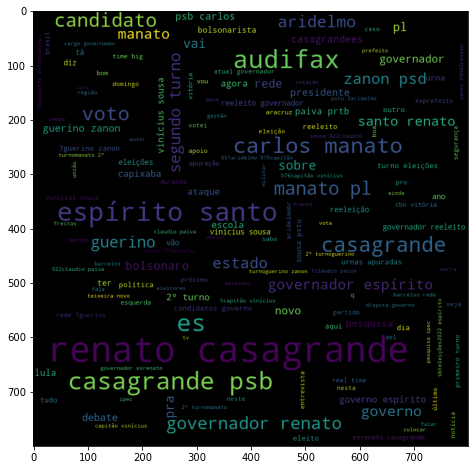

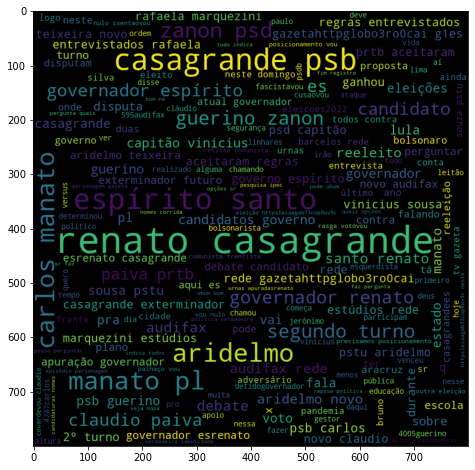

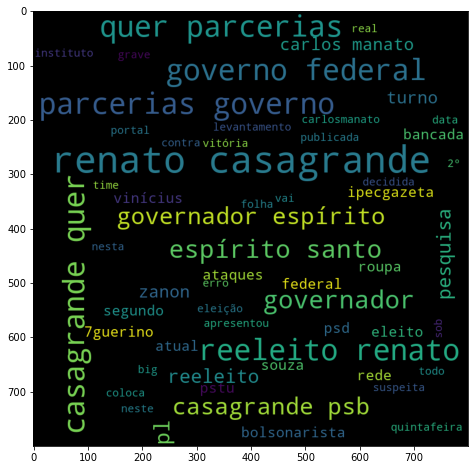

In [488]:
#Casagrande
#Positivo
palavras_csg_pos = ''
for tweet in tweets_casagrande_positivo['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_csg_pos += " ".join(words)+" "
    
wc_csg_pos = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_csg_pos)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_csg_pos)

#Neutro
palavras_csg_neu = ''
for tweet in tweets_casagrande_neutros['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_csg_neu += " ".join(words)+" "
    
wc_csg_neu = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_csg_neu)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_csg_neu)

#Negativo
palavras_csg_neg = ''
for tweet in tweets_casagrande_negativo['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_csg_neg += " ".join(words)+" "
    
wc_csg_neg = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_csg_neg)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_csg_neg)


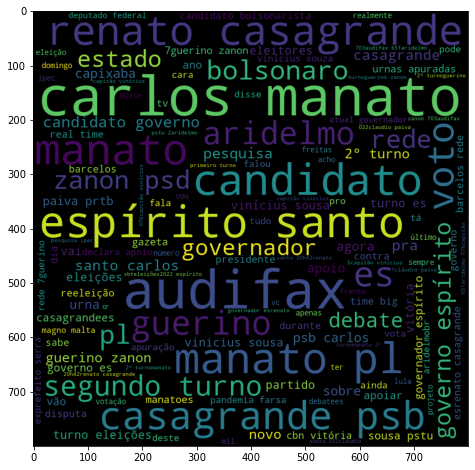

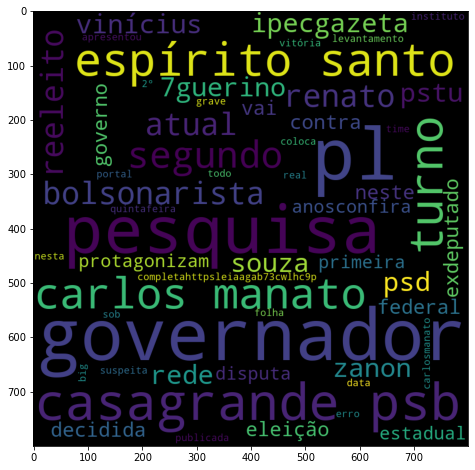

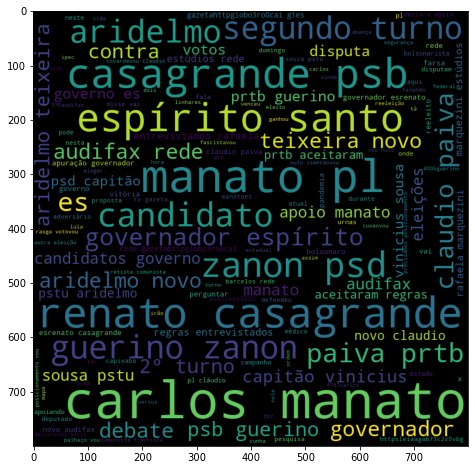

In [489]:
#Manato
#Positivo
palavras_man_pos = ''
for tweet in tweets_manato_positivo['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_man_pos += " ".join(words)+" "
    
wc_man_pos = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_man_pos)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_man_pos)

#Negativo
palavras_man_neg = ''
for tweet in tweets_manato_negativos['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_man_neg += " ".join(words)+" "
    
wc_man_neg = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_man_neg)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_man_neg)

#Neutro
palavras_man_neu = ''
for tweet in tweets_manato_neutro ['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_man_neu += " ".join(words)+" "
    
wc_man_neu = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_man_neu)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_man_neu)

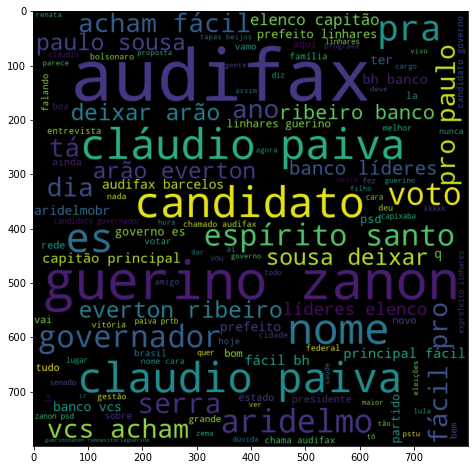

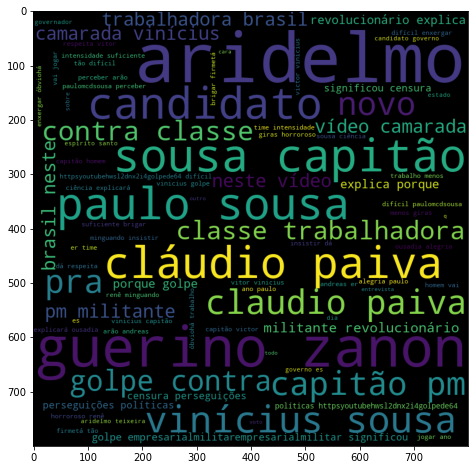

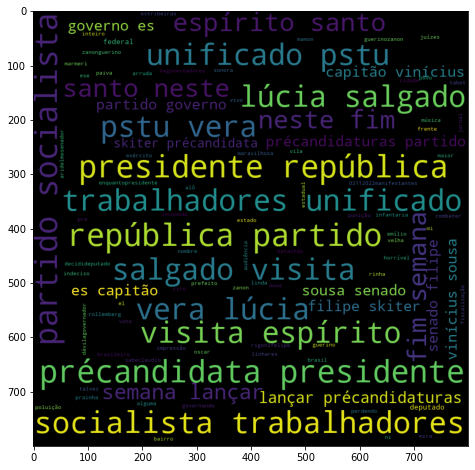

In [490]:
#Outros

#Positivo
palavras_out_pos = ''
for tweet in tweets_outros_positivo['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_out_pos += " ".join(words)+" "
    
wc_out_pos = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_out_pos)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_out_pos)

#Neutro
palavras_out_neu = ''
for tweet in tweets_outros_neutro ['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_out_neu += " ".join(words)+" "
    
wc_out_neu = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_out_neu)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_out_neu)

#Negativo
palavras_out_neg = ''
for tweet in tweets_outros_negativo ['Tweets']:
    tweetStr = str(tweet)
    words = tweetStr.split()
    
    for i in range(len(words)):
        words[i] = words[i].lower()
    palavras_out_neg += " ".join(words)+" "
    
wc_out_neu = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(palavras_out_neg)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc_out_neu)

## Gráficos - Análise dos Tweets

### Análise todos os tweets

<AxesSubplot:xlabel='classification'>

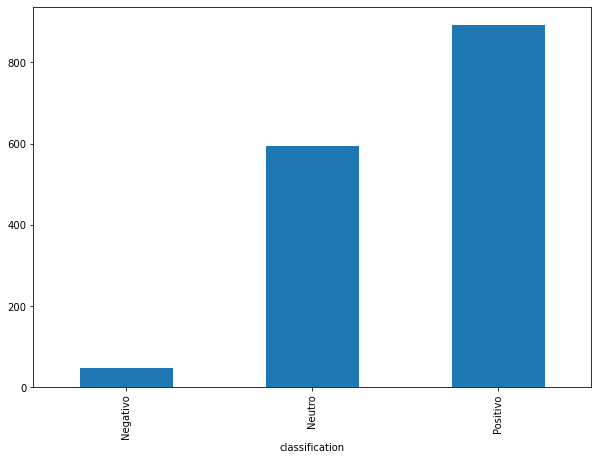

In [507]:
tweetsNovosDF.groupby('classification').size().plot(kind='bar', figsize=(10,7))

### Análise por candidato 2º turno - Casagrande X Manato

<AxesSubplot:xlabel='classification'>

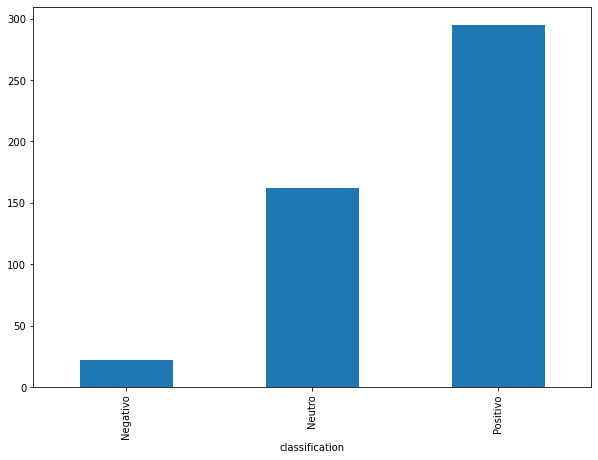

In [514]:
tweetsNovosDF.where(tweetsNovosDF["Tweets"].str.contains("Manato|manato")).groupby("classification").size().plot(kind='bar', figsize=(10,7))

<AxesSubplot:xlabel='classification'>

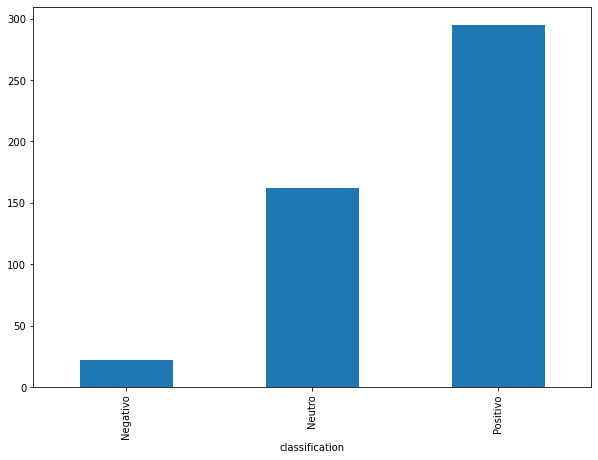

In [515]:
tweetsNovosDF.where(tweetsNovosDF["Tweets"].str.contains("Casagrande|casagrande")).groupby("classification").size().plot(kind='bar', figsize=(10,7))